# COURSE: A deep understanding of deep learning
## SECTION: Regularization
### LECTURE: Batch training in action
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/dudl/?couponCode=202208

In [1]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

In [3]:
# import dataset (comes with seaborn)
import seaborn as sns
iris = sns.load_dataset('iris')

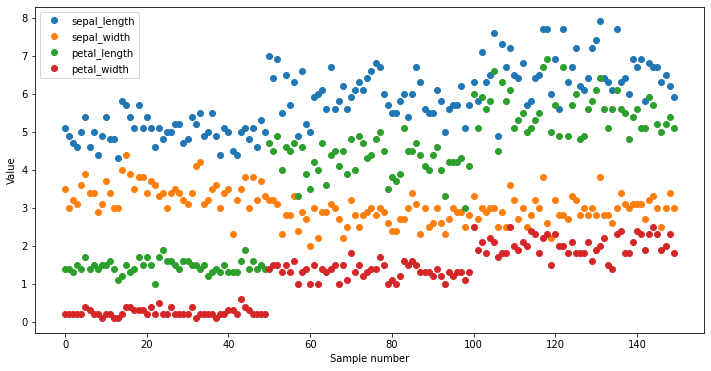

In [4]:
# plot the data
iris.plot(marker='o',linestyle='none',figsize=(12,6))
plt.xlabel('Sample number')
plt.ylabel('Value')
plt.show()

In [ ]:
####   ------------------------------- < NOTE ABOUT THIS CELL!!! > ---------------------------------------   ####
#                                                                                                               #
# The code here is intentionally commented out. We're going to use this in the lecture "The importance of       #
# data standardization" in the next section. If you're not doing that lecture, leave this commented! Thanks!    #
#                                                                                                               #
####   ------------------------------- </ NOTE ABOUT THIS CELL!!! > --------------------------------------   ####


# # z-score the data
# import scipy.stats as stats
# cols2zscore = iris.keys()
# cols2zscore = cols2zscore.drop('species')
# iris[cols2zscore] = iris[cols2zscore].apply(stats.zscore)

# iris.plot(marker='o',linestyle='none',figsize=(12,6))
# plt.xlabel('Sample number')
# plt.ylabel('Value')
# plt.show()

In [5]:
# organize the data

# convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa']   = 0 # don't need!
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica']  = 2

# Break the data into batches

In [6]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.2)


# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)


# finally, translate into dataloader objects
batchsize    = 16
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0]) # how big should these batches be??

In [7]:
# check sizes of data batches
for X,y in train_loader:
  print(X.shape,y.shape)

# go back and set drop_last=True in training DataLoader

torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])


# Construct the model and training plans

In [8]:
# a function that creates the ANN model

def createANewModel():

  # model architecture
  ANNiris = nn.Sequential(
      nn.Linear(4,64),   # input layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,64),  # hidden layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,3),   # output units
        )

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.0005)

  return ANNiris,lossfun,optimizer

In [65]:
# train the model

# global parameter
# numepochs = 2500

def trainTheModel(batch_size = 1, numepochs = 2500):   
    # use scikitlearn to split the data
    train_data,test_data, train_labels, test_labels = train_test_split(data, labels, test_size=.2)


    # then convert them into PyTorch Datasets (note: already converted to tensors)
    train_data = TensorDataset(train_data,train_labels)
    test_data  = TensorDataset(test_data,test_labels)


    # finally, translate into dataloader objects
    train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True,drop_last=True)
    test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0]) # how big should these batches be??


    # initialize accuracies as empties
    trainAcc = []
    testAcc  = []
    losses   = []

    # loop over epochs
    for epochi in range(numepochs):
        ANNiris.train()
        # loop over training data batches
        batchAcc  = []
        batchLoss = []
        for X,y in train_loader:

        # forward pass and loss
            yHat = ANNiris(X)
            loss = lossfun(yHat,y)
            
            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # compute training accuracy just for this batch
            batchAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
            batchLoss.append( loss.item() )
            # end of batch loop...

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append( np.mean(batchAcc) )
        losses.append( np.mean(batchLoss) )

        # test accuracy
        ANNiris.eval()
        with torch.no_grad():
            X,y = next(iter(test_loader)) # extract X,y from test dataloader
            predlabels = torch.argmax( ANNiris(X),axis=1 )
        testAcc.append( 100*torch.mean((predlabels == y).float()).item() )
    
    # function output
    return trainAcc,testAcc,losses


# Test it out

In [66]:
# create a model
ANNiris,lossfun,optimizer = createANewModel()

In [78]:
# train the model
trainAccs = {}
testAccs = {}
losses_dict = {}
for i in range(1,7):
    batch_size = 2**i
    ANNiris,lossfun,optimizer = createANewModel()
    trainAcc,testAcc,losses = trainTheModel(numepochs=500, batch_size=batch_size)
    trainAccs[batch_size] = trainAcc
    testAccs[batch_size] = testAcc
    losses_dict[batch_size] = losses

In [79]:
import pandas as pd

In [80]:
trainAccs = pd.DataFrame(trainAccs)
trainAccs.transpose()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
2,35.833333,35.833333,35.833333,35.833333,35.833333,35.833333,38.333333,40.833333,50.000000,60.000000,...,98.333333,98.333333,98.333333,98.333333,98.333333,98.333333,98.333333,98.333333,98.333333,98.333333
4,34.166667,54.166667,67.500000,67.500000,67.500000,66.666667,65.833333,66.666667,65.833333,67.500000,...,97.500000,96.666667,96.666667,97.500000,96.666667,97.500000,97.500000,96.666667,97.500000,96.666667
8,31.666667,31.666667,31.666667,31.666667,31.666667,31.666667,31.666667,31.666667,31.666667,32.500000,...,96.666667,96.666667,96.666667,97.500000,97.500000,96.666667,97.500000,96.666667,96.666667,96.666667
16,52.678571,44.642857,37.500000,37.500000,35.714286,33.928571,33.035714,32.142857,35.714286,33.928571,...,88.392857,91.071429,86.607143,86.607143,88.392857,86.607143,86.607143,91.071429,87.500000,88.392857
32,35.416667,31.250000,33.333333,33.333333,34.375000,31.250000,28.125000,33.333333,34.375000,42.708333,...,65.625000,65.625000,70.833333,67.708333,68.750000,67.708333,70.833333,65.625000,68.750000,69.791667
64,31.250000,32.812500,34.375000,40.625000,37.500000,32.812500,39.062500,39.062500,32.812500,32.812500,...,40.625000,35.937500,32.812500,39.062500,43.750000,42.187500,37.500000,42.187500,48.437500,45.312500


In [81]:
testAccs = pd.DataFrame(testAccs)
testAccs

,2,4,8,16,32,64
0,23.333333,30.000001,40.000001,53.333336,33.333334,26.666668
1,23.333333,63.333333,40.000001,46.666667,33.333334,26.666668
2,23.333333,63.333333,40.000001,36.666667,33.333334,26.666668
3,23.333333,63.333333,40.000001,33.333334,33.333334,26.666668
4,23.333333,63.333333,40.000001,33.333334,33.333334,26.666668
...,...,...,...,...,...,...
495,93.333334,100.000000,100.000000,86.666667,66.666669,50.000000
496,93.333334,100.000000,100.000000,86.666667,66.666669,50.000000
497,93.333334,100.000000,100.000000,86.666667,66.666669,50.000000
498,93.333334,100.000000,100.000000,86.666667,66.666669,53.333336


In [82]:
losses_dict = pd.DataFrame(losses_dict)
losses_dict

,2,4,8,16,32,64
0,1.096266,1.113528,1.098358,1.063506,1.102640,1.171861
1,1.071768,1.079388,1.083099,1.059700,1.116549,1.150509
2,1.052507,1.055122,1.070154,1.057753,1.105652,1.131445
3,1.036412,1.035727,1.058933,1.053404,1.092809,1.069261
4,1.023012,1.019907,1.049252,1.052345,1.094975,1.092347
...,...,...,...,...,...,...
495,0.071775,0.143632,0.229211,0.499257,0.740930,0.906666
496,0.070896,0.143734,0.229187,0.498686,0.732405,0.932854
497,0.070441,0.142342,0.228442,0.481842,0.749946,0.923167
498,0.070098,0.141990,0.227600,0.496700,0.740310,0.904468


In [83]:
plt.plot??

In [84]:
trainAccs.columns

Int64Index([2, 4, 8, 16, 32, 64], dtype='int64')

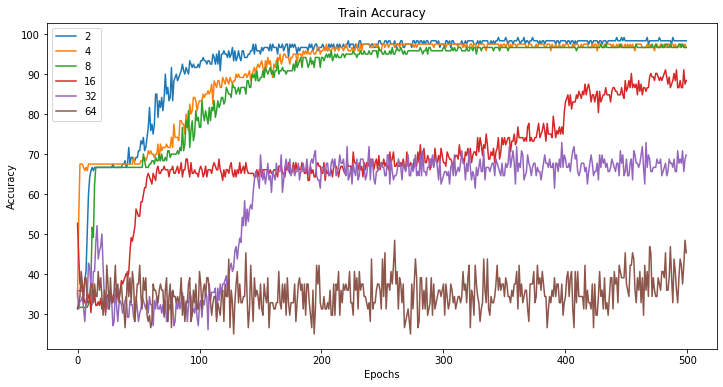

In [85]:
# fig, ax = plt.subplots(1,3, figsize=(12,4))
plt.rcParams["figure.figsize"] = (12, 6)
for column in trainAccs.columns:
    plt.plot(trainAccs[column],)

plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Train Accuracy')
plt.legend(trainAccs.columns)

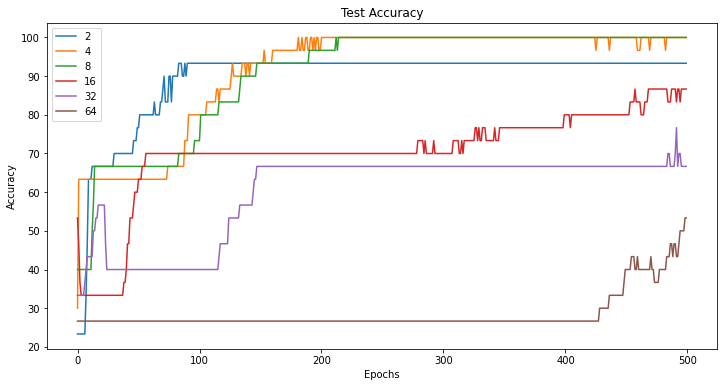

In [86]:
# fig, ax = plt.subplots(1,3, figsize=(12,4))
for column in testAccs.columns:
    plt.plot(testAccs[column])

plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Test Accuracy')
plt.legend(testAccs.columns)

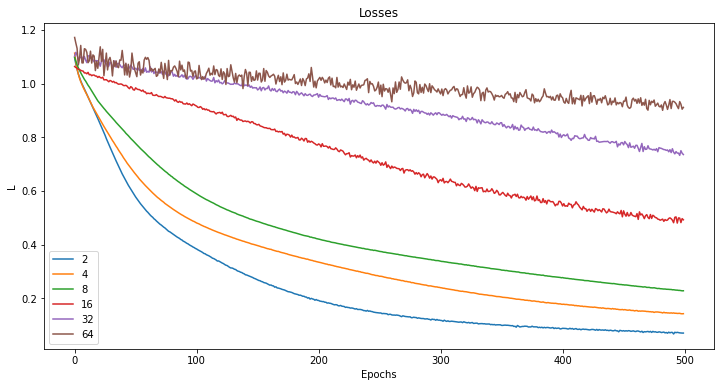

In [87]:
for column in losses_dict.columns:
    plt.plot(losses_dict[column])

plt.ylabel('L')
plt.xlabel('Epochs')
plt.title('Losses')
plt.legend(losses_dict.columns)

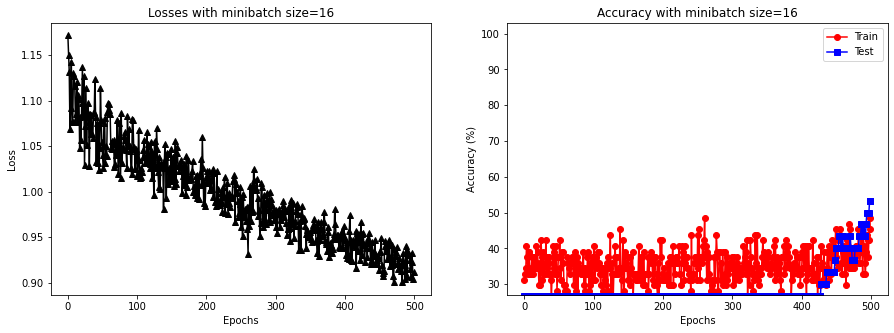

In [88]:
# plot the results
fig,ax = plt.subplots(1,2,figsize=(15,5))


ax[0].plot(losses,'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses with minibatch size=' + str(batchsize))

ax[1].plot(trainAcc,'ro-')
ax[1].plot(testAcc,'bs-')
ax[1].set_title('Accuracy with minibatch size=' + str(batchsize))
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train','Test'])
ax[1].set_ylim([27,103])

plt.show()

# Additional explorations

In [89]:
# 1) Is there a relationship between the test_size parameter in train_test_split(), the batchsize parameter in DataLoader,
#    and the length of test_data? Think of your answer first, then test it in code, by creating new dataloader objects 
#    with varying test_size parameters.
#    Hint: You can use the code 'len(test_data.dataset.tensors[1])', which returns the length of the labels vector.
# 
# 2) Let's say you didn't care about the three types of irises; you only want a model that labels a flower as setosa or 
#    "other." What would you have to change in the data and in the model to make this work?
# 
# 3) In the course section "More on data," you will learn that unbalanced designs can be problematic for DL models (an
#    unbalanced design means that there is an uneven distribution of samples in different categories). Does the 
#    modification in #2 produce an unbalanced design? To find out, count the number of data labels that are 0 (setosa) or
#    1 (not setosa).
# 